### Lets try the same training setup, but use some built in transforms

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
import torchvision.models.video as video_models
import torch.nn as nn
import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import json

from train import train_model_3
import video_dataset as Dataset
from test import test_model


/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
2025-07-18 15:45:43.459641: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-18 15:45:43.674946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-18 15:45:43.744747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for p

In [3]:
model_2 = video_models.r3d_18(pretrained=True)
num_classes = 100
train_inst_path = './preprocessed/labels/asl100/train_instances_fixed_bboxes_short.json'
val_inst_path = './preprocessed/labels/asl100/val_instances_fixed_bboxes_short.json'
raw_path = '../data/WLASL2000'
classes_path = './wlasl_class_list.json'
transform2 = transforms.Compose([
  transforms.Lambda(lambda x: Dataset.correct_num_frames(x, 16)),  # (T, C, H, W)
  transforms.Lambda(lambda x: x.float() / 255.0),  # Convert
  transforms.Lambda(lambda x: F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)),  # Resize after normalization
  transforms.Lambda(lambda x: Dataset.normalise(x, mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989])),  # Normalize per channel
  transforms.Lambda(lambda x: x.permute(1, 0, 2, 3)),  # (T, C, H, W) -> (C, T, H, W)
]) #This time trying the recommended transforms, also increasing resolution

train_set_2 = Dataset.VideoDataset(
  root=raw_path,
  instances_path=train_inst_path,
  classes_path=classes_path,
  transform=transform2
)
val_set_2 = Dataset.VideoDataset(
  root=raw_path,
  instances_path=val_inst_path,
  classes_path=classes_path,
  transform=transform2
)
print(f"Number of training samples: {len(train_set_2)}")
print(f"Number of validation samples: {len(val_set_2)}")


/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of training samples: 1442
Number of validation samples: 338


In [ ]:
train_loader_2 = DataLoader(
  train_set_2,
  batch_size=8, #I increased the resolution, so batch size is lower
  shuffle=True,
  num_workers=2, # but can be set to 4
  drop_last=True,
)
val_loader_2 = DataLoader(
  val_set_2,
  batch_size=16, #apparently can be mroe than train batch size
  num_workers=2, 
  shuffle=False,
  drop_last=False
)
print(f"Train loader:\n{train_loader_2}")
print(f"Validation loader:\n{val_loader_2}")

Train loader:
Validation loader:


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
model_2.fc = nn.Linear(model_2.fc.in_features, num_classes)
model_2 = model_2.to(device)

for param in model_2.parameters():
  param.requires_grad = True
  
for layer_name in ['layer4', 'fc']:
  if hasattr(model_2, layer_name):
    for param in getattr(model_2, layer_name).parameters():
      param.requires_grad = True
      
for name, param in model_2.named_parameters():
  if param.requires_grad:
    print(f"Training parameter: {name}")
  else:
    print(f"Freezing parameter: {name}")
    
for name, module in model_2.named_modules():
  if isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
    # Check if this BatchNorm is in a frozen layer
    is_in_frozen_layer = not any(unfreeze_layer in name for unfreeze_layer in ['layer4', 'fc'])
    
    if is_in_frozen_layer:
      module.eval()
      module.track_running_stats = False
      print(f"Set {name} to eval mode (frozen layer)")

Training parameter: stem.0.weight
Training parameter: stem.1.weight
Training parameter: stem.1.bias
Training parameter: layer1.0.conv1.0.weight
Training parameter: layer1.0.conv1.1.weight
Training parameter: layer1.0.conv1.1.bias
Training parameter: layer1.0.conv2.0.weight
Training parameter: layer1.0.conv2.1.weight
Training parameter: layer1.0.conv2.1.bias
Training parameter: layer1.1.conv1.0.weight
Training parameter: layer1.1.conv1.1.weight
Training parameter: layer1.1.conv1.1.bias
Training parameter: layer1.1.conv2.0.weight
Training parameter: layer1.1.conv2.1.weight
Training parameter: layer1.1.conv2.1.bias
Training parameter: layer2.0.conv1.0.weight
Training parameter: layer2.0.conv1.1.weight
Training parameter: layer2.0.conv1.1.bias
Training parameter: layer2.0.conv2.0.weight
Training parameter: layer2.0.conv2.1.weight
Training parameter: layer2.0.conv2.1.bias
Training parameter: layer2.0.downsample.0.weight
Training parameter: layer2.0.downsample.1.weight
Training parameter: la

In [ ]:
# trainable_params_2 = [p for p in model_2.parameters() if p.requires_grad]
# optimizer_2 = torch.optim.Adam(trainable_params_2, lr=1e-4)  # Adjust learning rate as needed
# loss_func = nn.CrossEntropyLoss()
# train_losses_2, val_losses_2 = train_model_3(
#   model=model_2,
#   train_loader=train_loader_2,
#   optimizer=optimizer_2,
#   loss_func=loss_func,
#   epochs=30,
#   val_loader=val_loader_2,
#   output='runs/r3d18_exp3'
# )

#the model crashed partway through training, so I will load the checkpoint and continue training
trainable_params_2 = [p for p in model_2.parameters() if p.requires_grad]
optimizer_2 = torch.optim.Adam(trainable_params_2, lr=1e-4)  # Adjust learning rate as needed
loss_func = nn.CrossEntropyLoss()
train_losses_2, val_losses_2 = train_model_3(
  model=model_2,
  train_loader=train_loader_2,
  optimizer=optimizer_2,
  loss_func=loss_func,
  epochs=30,
  val_loader=val_loader_2,
  output='runs/r3d18_exp2',
  load='runs/r3d18_exp2/checkpoints/checkpoint_2.pth'
)

Resuming from epoch 3
Loaded model from runs/r3d18_exp2/checkpoints/checkpoint_2.pth


Training R3D:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch [4/30], Train Loss: 2.3027, Val Loss: 3.5003


Training R3D:   4%|▎         | 1/27 [03:36<1:33:43, 216.29s/it]

Epoch [5/30], Train Loss: 1.5025, Val Loss: 3.3028


Training R3D:   7%|▋         | 2/27 [07:13<1:30:15, 216.64s/it]

Epoch [6/30], Train Loss: 0.8012, Val Loss: 3.3517


Training R3D:  11%|█         | 3/27 [10:49<1:26:40, 216.70s/it]

Epoch [7/30], Train Loss: 0.3738, Val Loss: 3.2620


Training R3D:  15%|█▍        | 4/27 [14:26<1:23:06, 216.81s/it]

Epoch [8/30], Train Loss: 0.2096, Val Loss: 3.2487


Training R3D:  19%|█▊        | 5/27 [18:03<1:19:28, 216.77s/it]

Epoch [9/30], Train Loss: 0.1324, Val Loss: 3.2956


Training R3D:  22%|██▏       | 6/27 [21:40<1:15:52, 216.79s/it]

Epoch [10/30], Train Loss: 0.0945, Val Loss: 3.3019


Training R3D:  26%|██▌       | 7/27 [25:17<1:12:16, 216.82s/it]

Epoch [11/30], Train Loss: 0.0725, Val Loss: 3.2577


Training R3D:  30%|██▉       | 8/27 [28:54<1:08:39, 216.82s/it]

Epoch [12/30], Train Loss: 0.0635, Val Loss: 3.2647


Training R3D:  33%|███▎      | 9/27 [32:30<1:05:02, 216.82s/it]

Epoch [13/30], Train Loss: 0.0508, Val Loss: 3.2254


Training R3D:  37%|███▋      | 10/27 [36:08<1:01:27, 216.93s/it]

Epoch [14/30], Train Loss: 0.0476, Val Loss: 3.1529


Training R3D:  41%|████      | 11/27 [39:45<57:51, 216.94s/it]  

Epoch [15/30], Train Loss: 0.0378, Val Loss: 3.1326


Training R3D:  44%|████▍     | 12/27 [43:22<54:14, 216.96s/it]

Epoch [16/30], Train Loss: 0.0355, Val Loss: 3.0877


Training R3D:  48%|████▊     | 13/27 [46:59<50:37, 216.97s/it]

Epoch [17/30], Train Loss: 0.0303, Val Loss: 3.2019


Training R3D:  52%|█████▏    | 14/27 [50:35<46:59, 216.92s/it]

Epoch [18/30], Train Loss: 0.0314, Val Loss: 3.1888


Training R3D:  56%|█████▌    | 15/27 [54:12<43:22, 216.89s/it]

Epoch [19/30], Train Loss: 0.0326, Val Loss: 3.1443


Training R3D:  59%|█████▉    | 16/27 [57:48<39:42, 216.55s/it]

Epoch [20/30], Train Loss: 0.0627, Val Loss: 3.2111


Training R3D:  63%|██████▎   | 17/27 [1:01:21<35:54, 215.42s/it]

Epoch [21/30], Train Loss: 0.0400, Val Loss: 3.4378


Training R3D:  67%|██████▋   | 18/27 [1:04:54<32:12, 214.69s/it]

Epoch [22/30], Train Loss: 0.0404, Val Loss: 3.0758


Training R3D:  70%|███████   | 19/27 [1:08:27<28:33, 214.21s/it]

Epoch [23/30], Train Loss: 0.0391, Val Loss: 3.2051


Training R3D:  74%|███████▍  | 20/27 [1:12:00<24:56, 213.77s/it]

Epoch [24/30], Train Loss: 0.0252, Val Loss: 3.2058


Training R3D:  78%|███████▊  | 21/27 [1:15:32<21:20, 213.46s/it]

Epoch [25/30], Train Loss: 0.0207, Val Loss: 3.0824


Training R3D:  81%|████████▏ | 22/27 [1:19:05<17:46, 213.28s/it]

Epoch [26/30], Train Loss: 0.0159, Val Loss: 3.1215


Training R3D:  85%|████████▌ | 23/27 [1:22:38<14:12, 213.20s/it]

Epoch [27/30], Train Loss: 0.0137, Val Loss: 3.2156


Training R3D:  89%|████████▉ | 24/27 [1:26:11<10:39, 213.07s/it]

Epoch [28/30], Train Loss: 0.0115, Val Loss: 3.1786


Training R3D:  93%|█████████▎| 25/27 [1:29:44<07:06, 213.06s/it]

Epoch [29/30], Train Loss: 0.0112, Val Loss: 3.2425


Training R3D:  96%|█████████▋| 26/27 [1:33:17<03:32, 212.89s/it]

### cuda out of memory with batch size (train) of 16, but gets very similar utilisation to previous experiment, but with 8 frames

| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |

| 48%   71C    P2            290W /  300W |    7100MiB /  11264MiB |    100%      Default |

### The model crashed partway though again, likely due to too many processes (machien ground to a halt first)

In [6]:
with open('runs/r3d18_exp2/logs/train_losses.json', 'r') as f:
  train_losses_2 = json.load(f)
with open('runs/r3d18_exp2/logs/val_losses.json', 'r') as f:
  val_losses_2 = json.load(f)  

In [2]:

transform2 = transforms.Compose([
  transforms.Lambda(lambda x: Dataset.correct_num_frames(x, 16)),  # (T, C, H, W)
  transforms.Lambda(lambda x: x.float() / 255.0),  # Convert
  transforms.Lambda(lambda x: F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)),  # Resize after normalization
  transforms.Lambda(lambda x: Dataset.normalise(x, mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989])),  # Normalize per channel
  transforms.Lambda(lambda x: x.permute(1, 0, 2, 3)),  # (T, C, H, W) -> (C, T, H, W)
]) #This time trying the recommended transforms, also increasing resolution


test_instnces_path = './preprocessed/labels/asl100/test_instances_fixed_bboxes_short.json'
raw_path = '../data/WLASL2000'
classes_path = './wlasl_class_list.json'
test_set = Dataset.VideoDataset(
  root=raw_path,
  instances_path=test_instnces_path,
  classes_path=classes_path,
  transform=transform2
)
test_loader = DataLoader(
  test_set,
  batch_size=32,  # Adjust batch size as needed
  shuffle=False,
  num_workers=2,  # Adjust number of workers as needed
  drop_last=False
)

In [3]:
import torchvision.models.video as video_models
model = video_models.r3d_18(pretrained=True)

num_classes = 100
model.fc = nn.Linear(model.fc.in_features, num_classes)
state = torch.load('runs/r3d18_exp2/checkpoints/checkpoint_28.pth')
model.load_state_dict(state['model_state_dict'])
accuracy, report = test_model(model, test_loader)
print(f"Test Accuracy: {accuracy:.4f}")

/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 0.2403


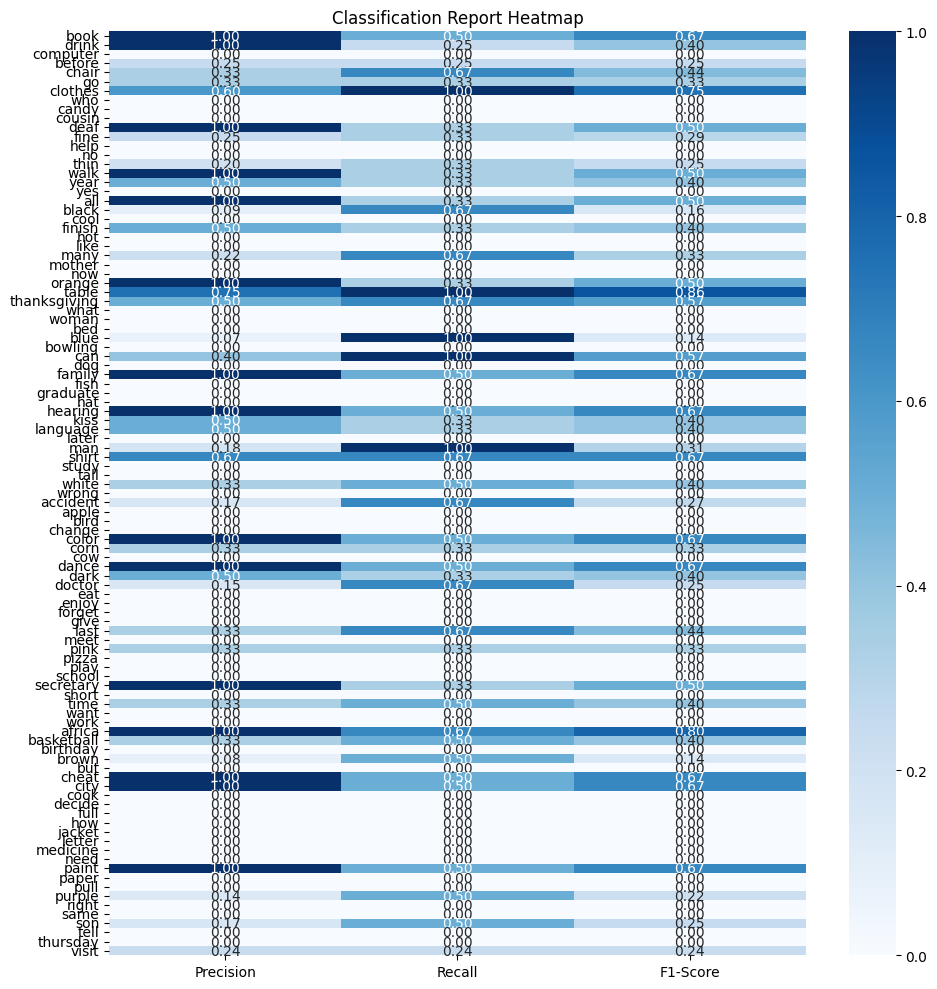

In [5]:
from test import plot_heatmap, plot_bar_graph
test_classes = test_set.classes
plot_heatmap(report, test_classes)


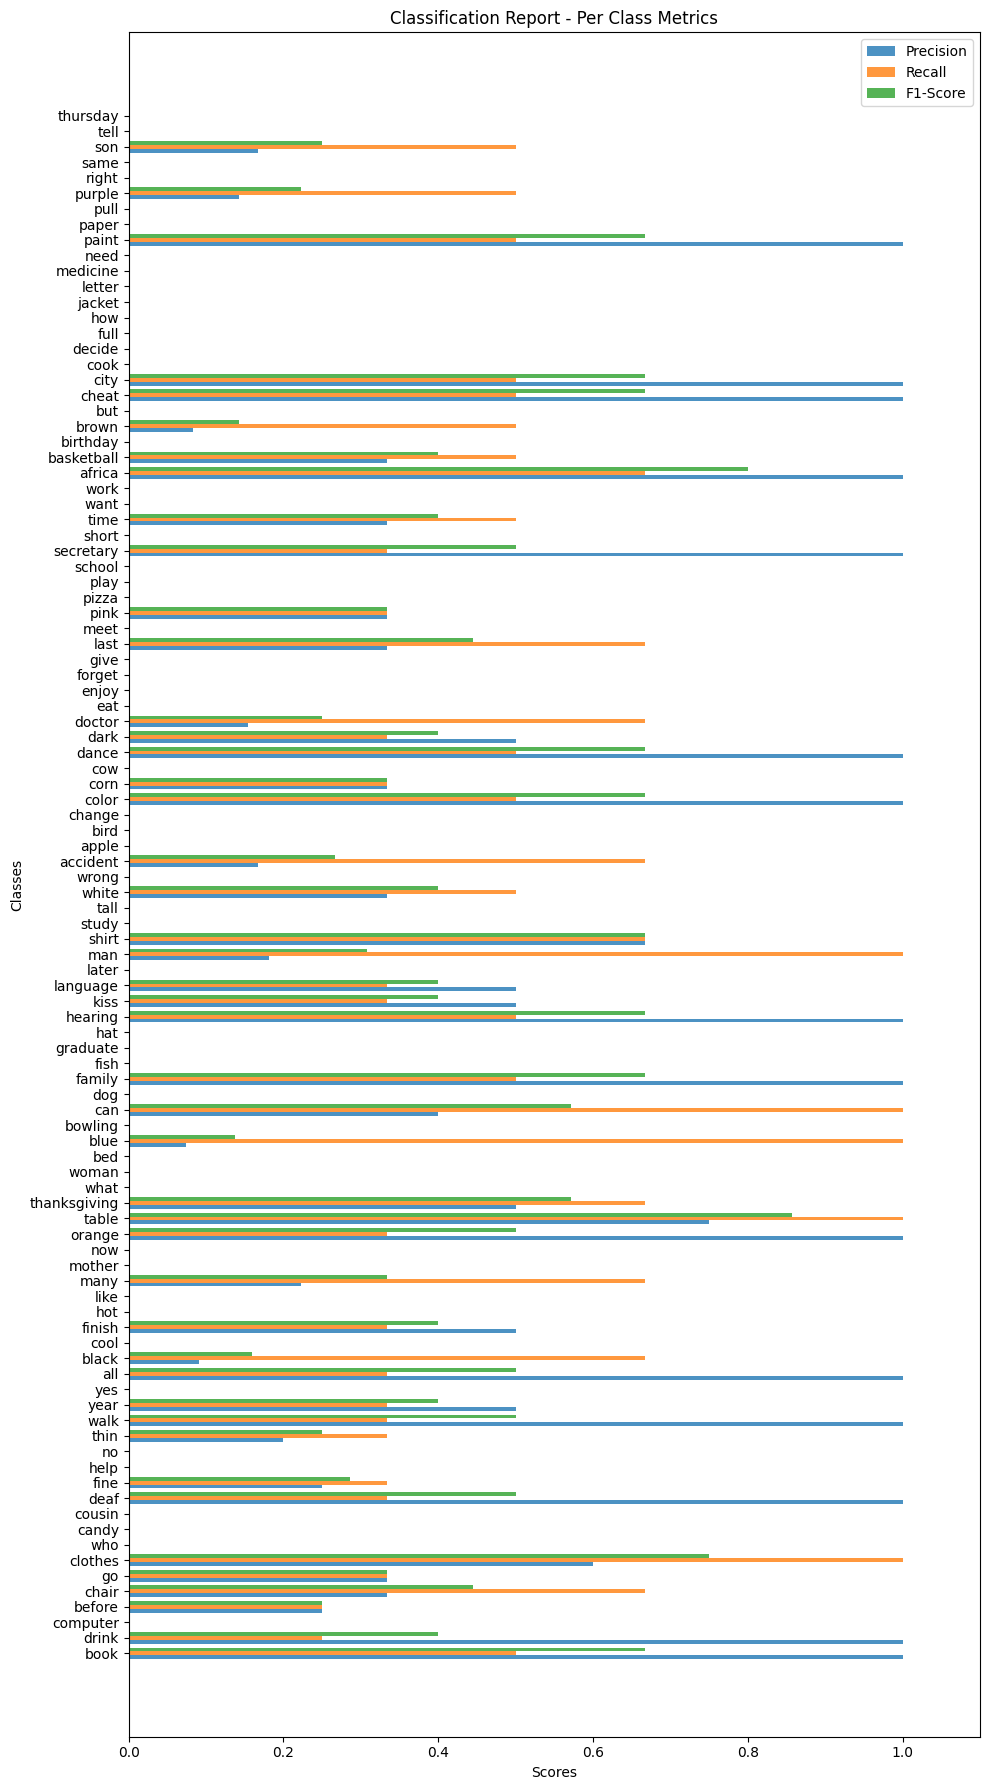

In [6]:
plot_bar_graph(report, test_classes[:100])

# Recieved very similar results to exp1